# SB5 — Sensitivity to noise

In [47]:

import os, sys, time, json, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown, HTML

# Ensure local modules are importable
ROOT = Path("/mnt/data").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import main  # uses /mnt/data/main.py
from evaluator import (
    load_logs, aggregate_regret, plot_regret_curves, add_normalized_regret,
    aggregate_regret_norm, plot_regret_norm_curves, plot_box_regret_at_T,
    plot_box_regret_norm_at_T, plot_box_best_value_at_T, plot_ybest_curves,
    rank_by_group, winrate_by_group, plot_rank_heatmap, plot_winrate_heatmap,
    save_rank_tables, save_tables, export_best_at_T_table,
    save_best_at_T_tables_as_png, render_boxplot_side_tables, export_auc_table_from_agg
)  # uses /mnt/data/evaluator.py

def find_latest_results(exp_name: str) -> Path:
    root = Path("results")
    if not root.exists():
        raise FileNotFoundError("No results/ folder yet.")
    cands = [p for p in root.glob(f"*_{exp_name}") if p.is_dir()]
    if not cands:
        # fallback: any folder containing exp_name
        cands = [p for p in root.glob("*_*") if exp_name in p.name]
    if not cands:
        raise FileNotFoundError(f"No results subfolder matching: {exp_name}")
    return max(cands, key=lambda p: p.stat().st_mtime)

def show_pngs(paths, width=820):
    for p in paths:
        p = Path(p)
        if p.exists():
            display(Image(filename=str(p), width=width))

def show_all_core_plots(outdir: Path):
    # Display the plots main.py already created when PLOT_IN_MAIN=True
    plots = outdir / "plots"
    # groups = [
    #     "regret_curves", "regret_curves_obs", "regret_norm_curves",
    #     "regret", "regret_obs", "regret_norm", "best_value", "heatmaps"
    # ]
    # groups = [
    #     "regret_curves", "regret_norm_curves",
    #     "regret", "regret_norm", "best_value", "heatmaps"
    # ]
    groups = [
        "regret_curves",
        "regret"
    ]
    all_imgs = []
    for g in groups:
        d = plots / g
        if d.exists():
            all_imgs += sorted(d.glob("*.png"))
    if all_imgs:
        print(f"Showing {len(all_imgs)} plot images ...")
        show_pngs(all_imgs)

    # # Also show the small per-boxplot side tables (PNG) if present
    # table_pngs = sorted((outdir/"plots").rglob("*_table.png"))
    # if table_pngs:
    #     print(f"Showing {len(table_pngs)} boxplot side-table PNGs ...")
    #     show_pngs(table_pngs, width=640)

    # # And global 'best_at_T' PNG tables
    # global_tables = sorted((outdir/"tables").glob("best_at_T_*.png"))
    # if global_tables:
    #     print("Global Best@T tables:")
    #     show_pngs(global_tables, width=720)

def show_core_dataframes(outdir: Path):
    # Load unified logs
    df = load_logs(outdir)
    print("all_runs.csv shape:", df.shape)
    # Final rows per run for boxplots
    keys = ["problem","method","seed","budget"]
    if "noise_pct" in df.columns:
        keys.append("noise_pct")
    dff = df.sort_values("iter").groupby(keys, as_index=False).tail(1)
    display(Markdown("**Final rows per run (for boxplots):**"))
    display(dff.head(20))

    # Aggregates for curves (true & observed regret)
    agg_true = aggregate_regret(df, use_observed=False)
    display(Markdown("**Aggregate (true regret) for curves:**"))
    display(agg_true.head(20))
    # agg_obs = aggregate_regret(df, use_observed=True)
    # display(Markdown("**Aggregate (observed regret) for curves:**"))
    # display(agg_obs.head(20))

    # Normalized regret
    dfn = add_normalized_regret(df.copy())
    if "regret_norm" in dfn.columns:
        aggn = aggregate_regret_norm(dfn)
        display(Markdown("**Aggregate (normalized regret) for curves:**"))
        display(aggn.head(20))


In [2]:

# --- CONFIG --------------------------------------------------------------
main.EXP_NAME      = 'SB5_Noise_sensitivity'
main.PROBLEMS      = ['Branin', 'Rosenbrock']
main.METHODS       = ['DOE_LHS', 'BO_EI', 'Random']
main.BUDGETS       = [20]
main.SEEDS         = list(range(40))
main.NOISE_PCTS    = [0.0, 0.05, 0.2, 0.5]
main.INIT_FACTOR   = 2.0
main.PLOT_IN_MAIN  = True
main.GENERATE_SAMPLES   = False
main.FINAL_SAMPLES_AT_T = True
main.K_EVERY            = 4
print("✓ CONFIG applied here (overrides main.py defaults during this run).")


✓ CONFIG applied here (overrides main.py defaults during this run).


In [45]:
def run_and_collect(exp_name: str):
    # main.main() uses current module-level config values set above.
    print("Launching main.main() ...")
    main.main()
    outdir = find_latest_results(exp_name)

    # Recompute aggregates and export AUC tables
    from evaluator import aggregate_regret, aggregate_regret_norm, add_normalized_regret, export_auc_table_from_agg
    df_all = load_logs(outdir)

    agg_true = aggregate_regret(df_all, use_observed=False)
    export_auc_table_from_agg(agg_true, outdir, label="true")

    # agg_obs = aggregate_regret(df_all, use_observed=True)
    # export_auc_table_from_agg(agg_obs, outdir, label="obs")

    dfn = add_normalized_regret(df_all.copy())
    if "regret_norm" in dfn.columns:
        aggn = aggregate_regret_norm(dfn)
        export_auc_table_from_agg(aggn, outdir, label="norm")

    print("Artifacts written to:", outdir)
    # Ensure all table PNGs exist (best@T + per-boxplot)
    try:
        save_best_at_T_tables_as_png(outdir, decimals=3)
    except Exception as e:
        print("[warn] save_best_at_T_tables_as_png:", e)
    try:
        render_boxplot_side_tables(outdir, decimals=3)
    except Exception as e:
        print("[warn] render_boxplot_side_tables:", e)
    return outdir


In [4]:
# --- HOTFIX 1: Entschärfe savefig, wenn bbox_inches="tight" kommt (ohne deinen Code zu ändern)
import matplotlib.pyplot as plt
from functools import wraps

_ORIG_SAVEFIG = plt.savefig

@wraps(_ORIG_SAVEFIG)
def _savefig_no_tight(*args, **kwargs):
    # Verhindert riesige Bounding Boxes durch "tight"
    if kwargs.get("bbox_inches") == "tight":
        kwargs["bbox_inches"] = None
    # Optional: DPI deckeln (beugt sehr großen PNGs vor)
    if "dpi" in kwargs and kwargs["dpi"] and kwargs["dpi"] > 120:
        kwargs["dpi"] = 120
    return _ORIG_SAVEFIG(*args, **kwargs)

plt.savefig = _savefig_no_tight
print("✓ Hotfix aktiv: savefig tight→standard, dpi≤120")


✓ Hotfix aktiv: savefig tight→standard, dpi≤120


In [5]:
# # --- HOTFIX 2 (optional): Median-Label-Annotator temporär ausknipsen
# import evaluator as ev
# if hasattr(ev, "_annotate_median_labels_next_to_lines"):
#     ev._annotate_median_labels_next_to_lines = lambda *a, **k: None
#     print("✓ Hotfix aktiv: Median-Labels in Main-Boxplots deaktiviert")


In [6]:
outdir = run_and_collect(main.EXP_NAME)

Launching main.main() ...
[run] Branin | DOE_LHS | seed=0 | T=20 | noise=0.00
[run] Branin | DOE_LHS | seed=0 | T=20 | noise=0.05
[run] Branin | DOE_LHS | seed=0 | T=20 | noise=0.20
[run] Branin | DOE_LHS | seed=0 | T=20 | noise=0.50
[run] Branin | DOE_LHS | seed=1 | T=20 | noise=0.00
[run] Branin | DOE_LHS | seed=1 | T=20 | noise=0.05
[run] Branin | DOE_LHS | seed=1 | T=20 | noise=0.20
[run] Branin | DOE_LHS | seed=1 | T=20 | noise=0.50
[run] Branin | DOE_LHS | seed=2 | T=20 | noise=0.00
[run] Branin | DOE_LHS | seed=2 | T=20 | noise=0.05
[run] Branin | DOE_LHS | seed=2 | T=20 | noise=0.20
[run] Branin | DOE_LHS | seed=2 | T=20 | noise=0.50
[run] Branin | DOE_LHS | seed=3 | T=20 | noise=0.00
[run] Branin | DOE_LHS | seed=3 | T=20 | noise=0.05
[run] Branin | DOE_LHS | seed=3 | T=20 | noise=0.20
[run] Branin | DOE_LHS | seed=3 | T=20 | noise=0.50
[run] Branin | DOE_LHS | seed=4 | T=20 | noise=0.00
[run] Branin | DOE_LHS | seed=4 | T=20 | noise=0.05
[run] Branin | DOE_LHS | seed=4 | T=20

C:\Users\marti\AppData\Local\Temp\ipykernel_50580\239053809.py:15: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  return _ORIG_SAVEFIG(*args, **kwargs)
C:\Users\marti\AppData\Local\Temp\ipykernel_50580\239053809.py:15: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  return _ORIG_SAVEFIG(*args, **kwargs)
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Da

Table PNGs: {'true': 'results\\20251101_163824_SB5_Noise_sensitivity\\tables\\best_at_T_by_seed_method_true.png', 'obs': 'results\\20251101_163824_SB5_Noise_sensitivity\\tables\\best_at_T_by_seed_method_obs.png', 'norm': 'results\\20251101_163824_SB5_Noise_sensitivity\\tables\\best_at_T_by_seed_method_norm.png'}
[warn] render_boxplot_side_tables failed: name '_df_apply_elementwise' is not defined
Report: results\20251101_163824_SB5_Noise_sensitivity\benchmark_report.html
[debug] all_runs shape: (19200, 21), columns: ['best_so_far', 'best_so_far_obs', 'budget', 'dim', 'exp_name', 'init_factor', 'iter', 'method', 'noise_pct', 'noise_seed', 'problem', 'regret', 'regret_obs', 'seed', 'sigma_noise', 'time_s', 'x', 'x_uv', 'x_xy', 'y', 'y_noisy']
Artifacts written to: results\20251101_163824_SB5_Noise_sensitivity


c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1907: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:1907: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Artifacts written to: results\20251101_163824_SB5_Noise_sensitivity


c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
c:\Users\marti\OneDrive\Documents\Bildung\Studium\Data_Science\IU-Data_Science\Abschlussarbeit\Code_Pipeline\Final-Sub-Benchmarks\evaluator.py:2125: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


[warn] render_boxplot_side_tables: name '_df_apply_elementwise' is not defined


Showing 16 plot images ...


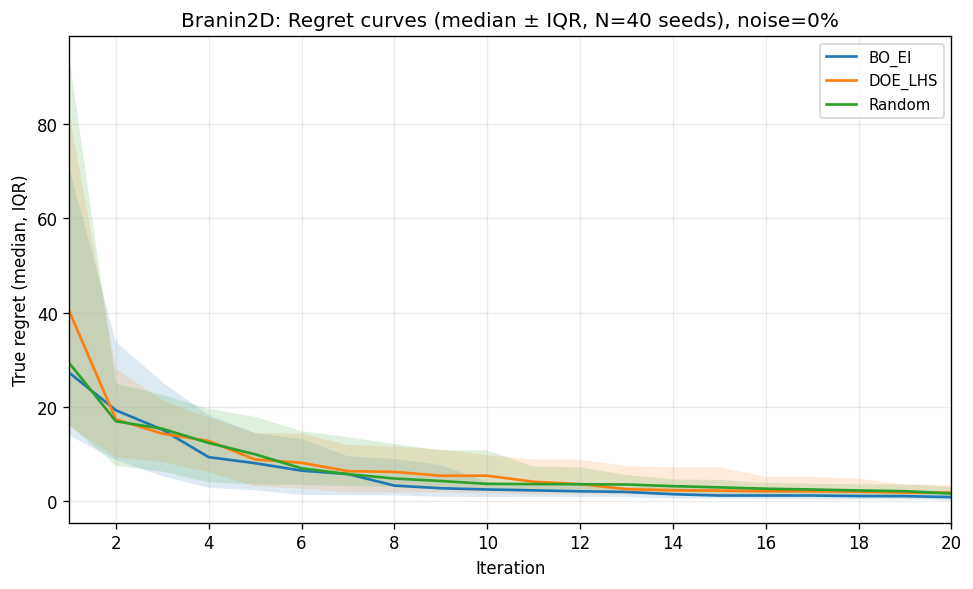

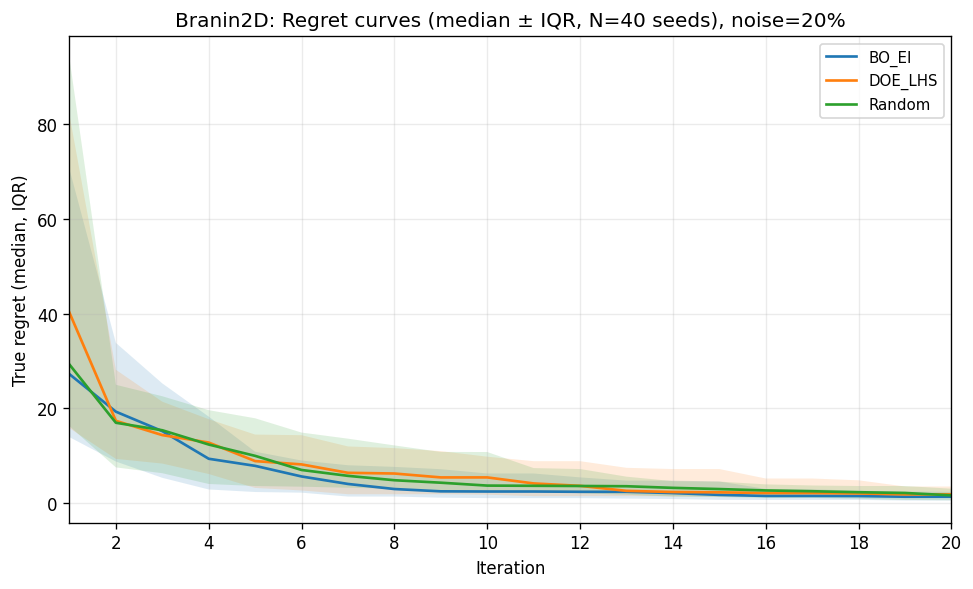

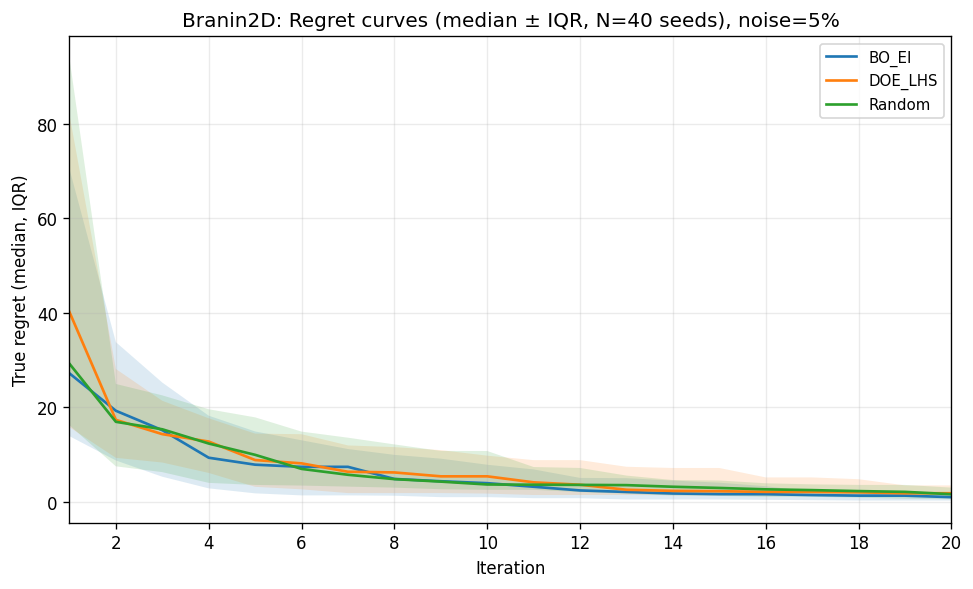

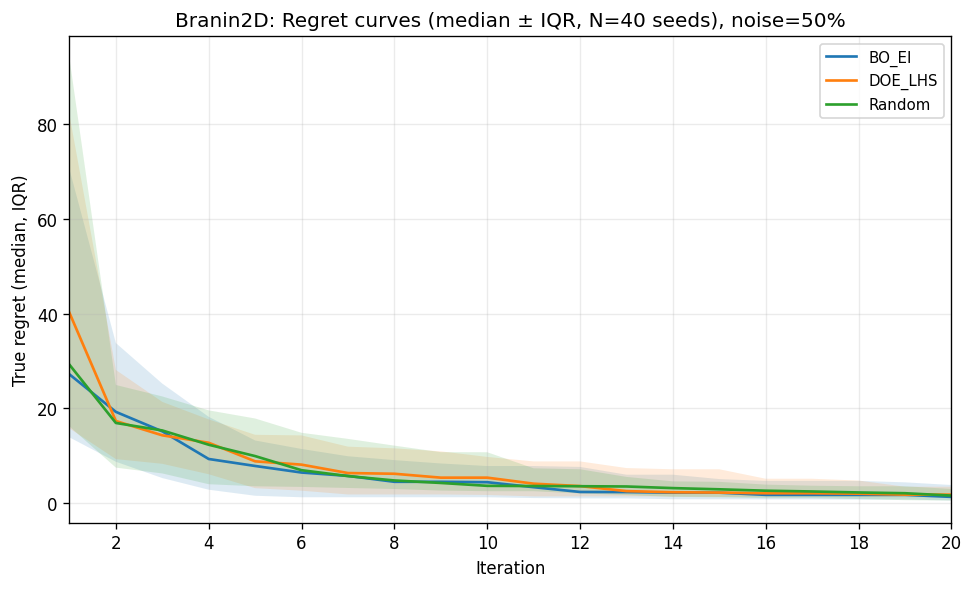

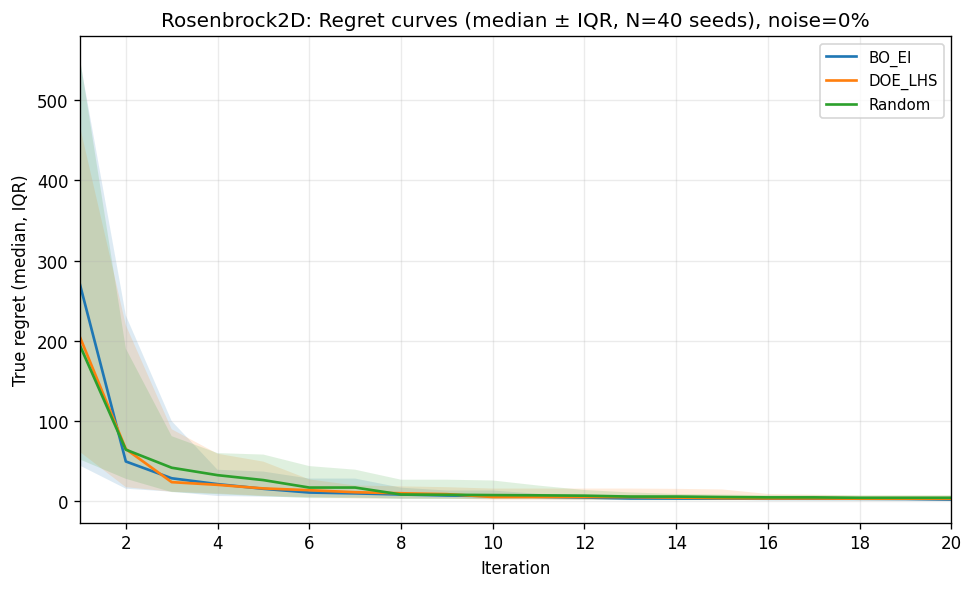

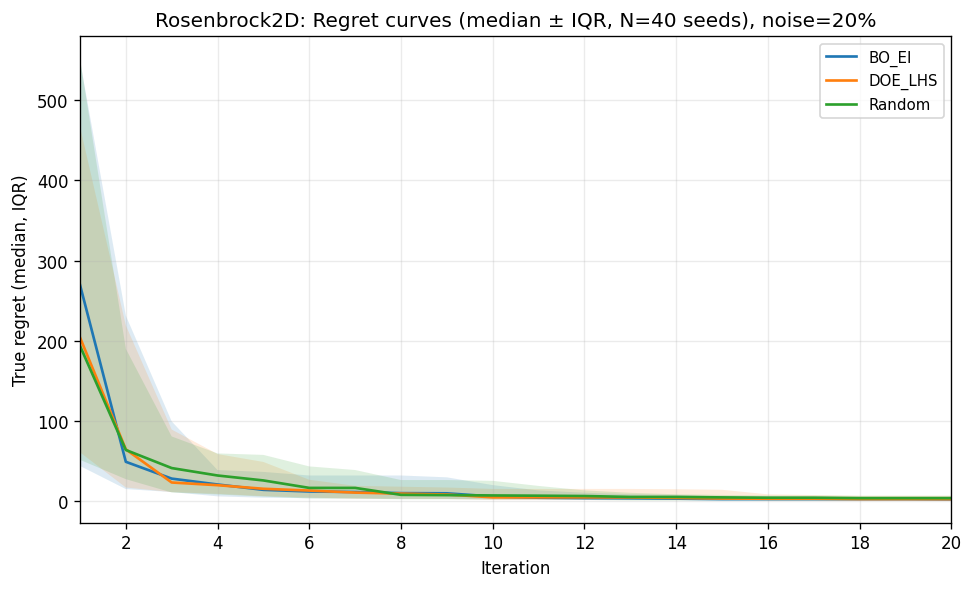

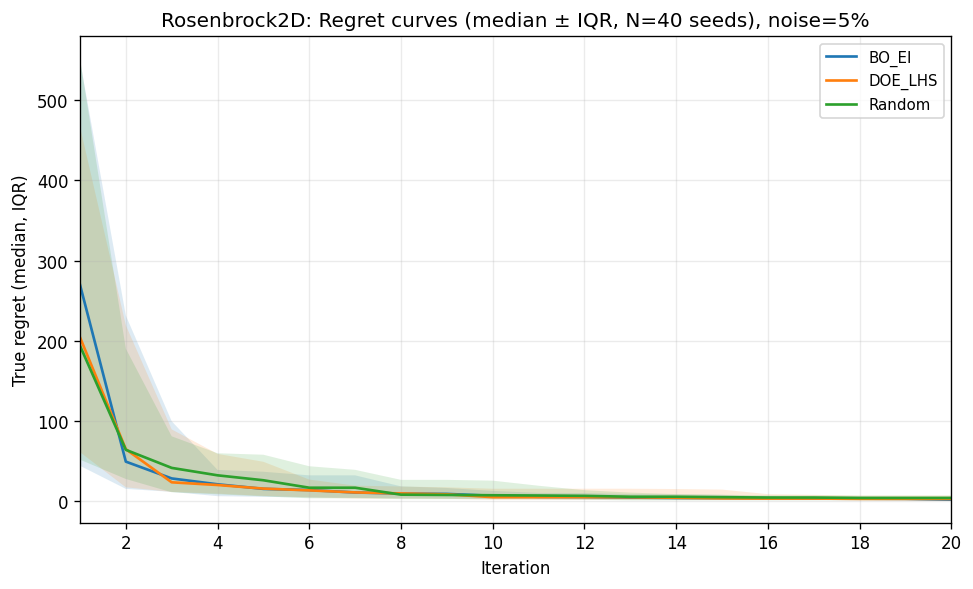

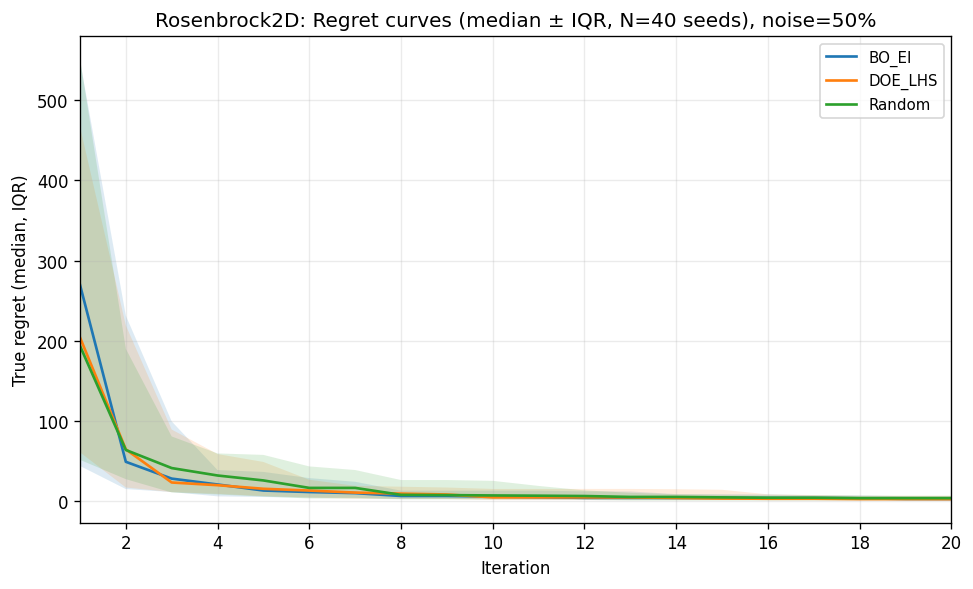

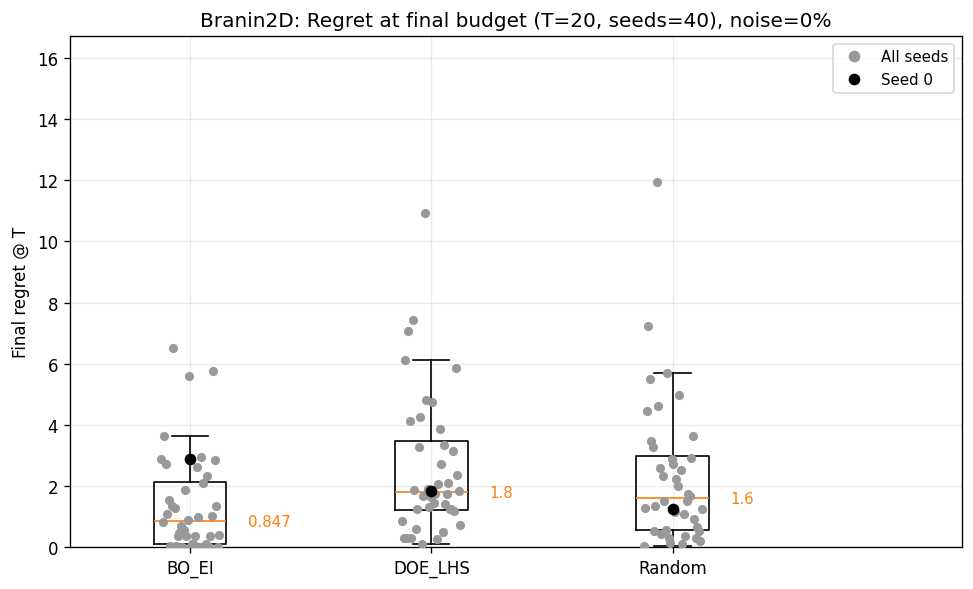

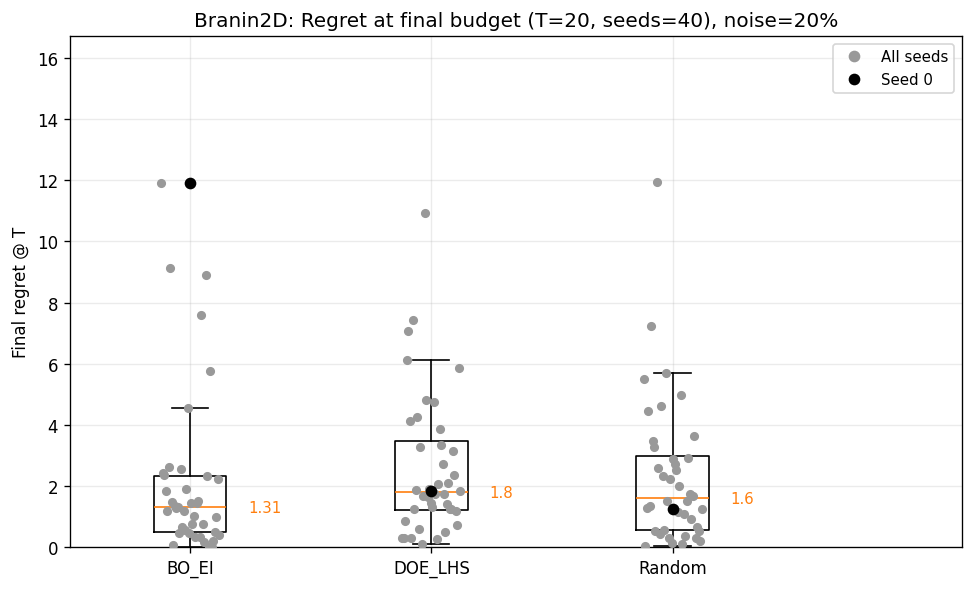

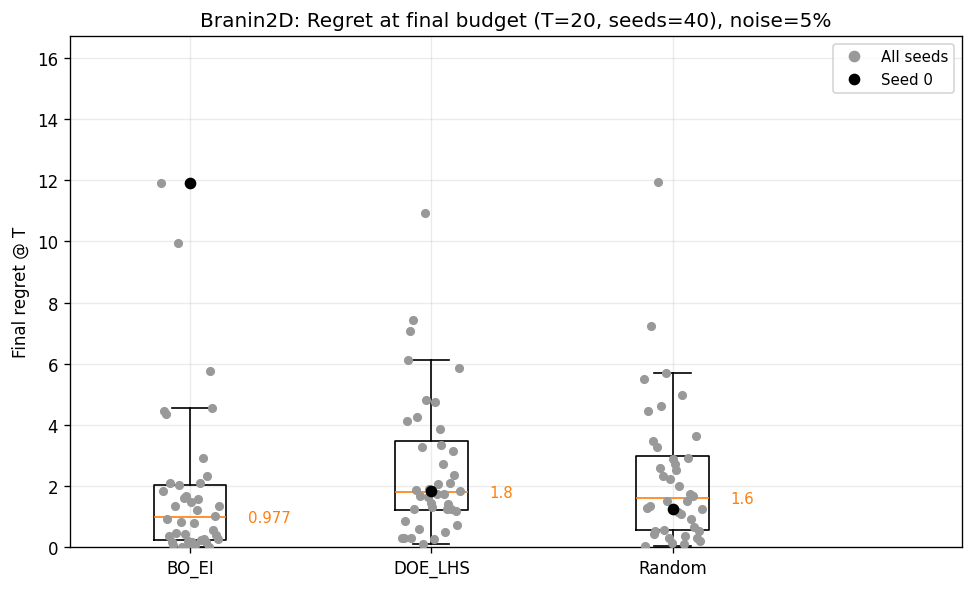

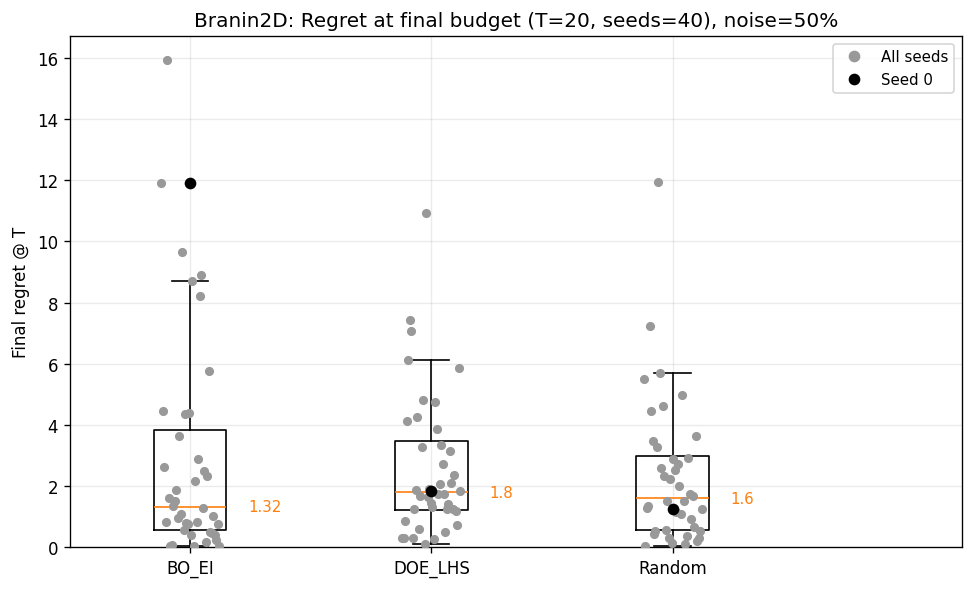

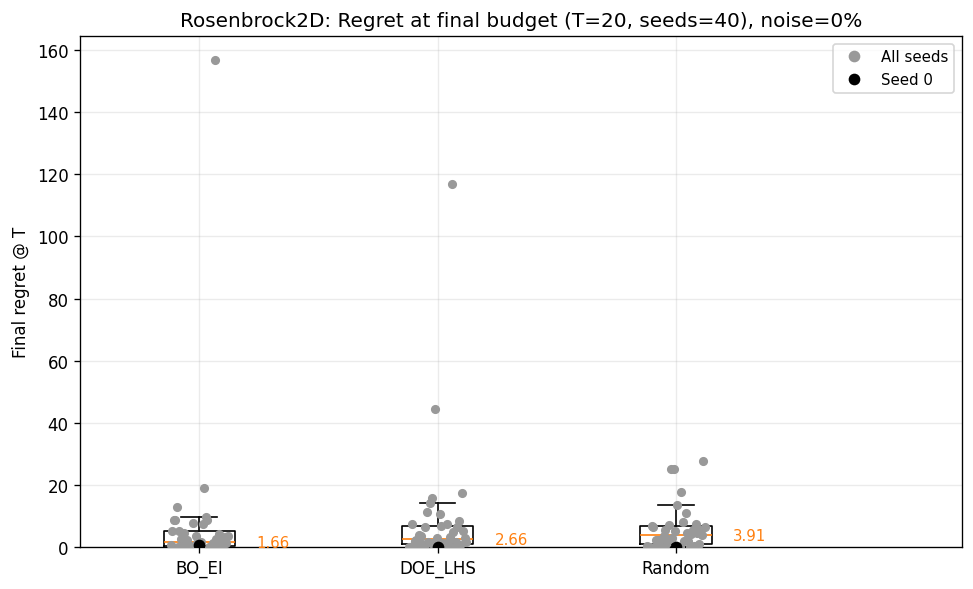

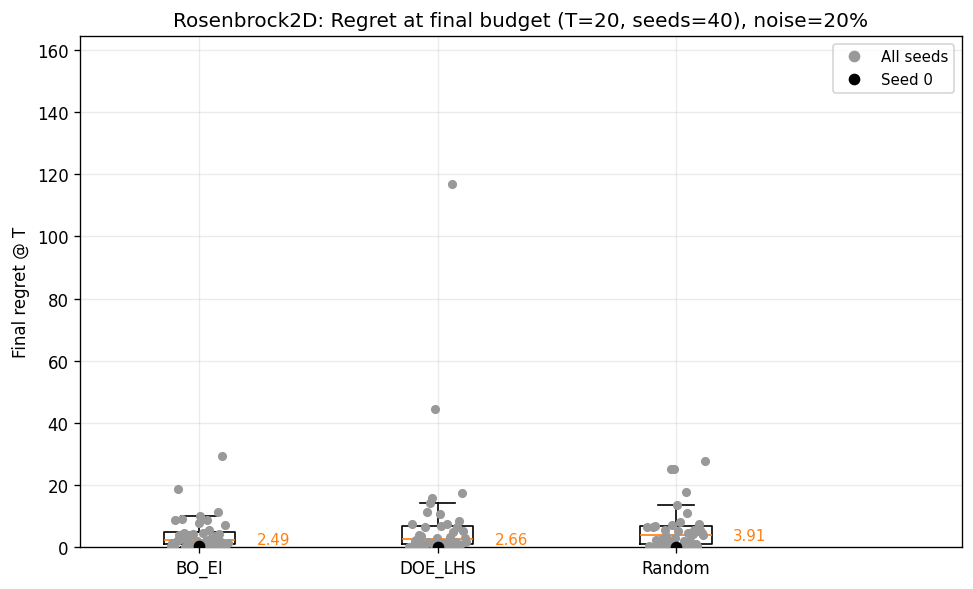

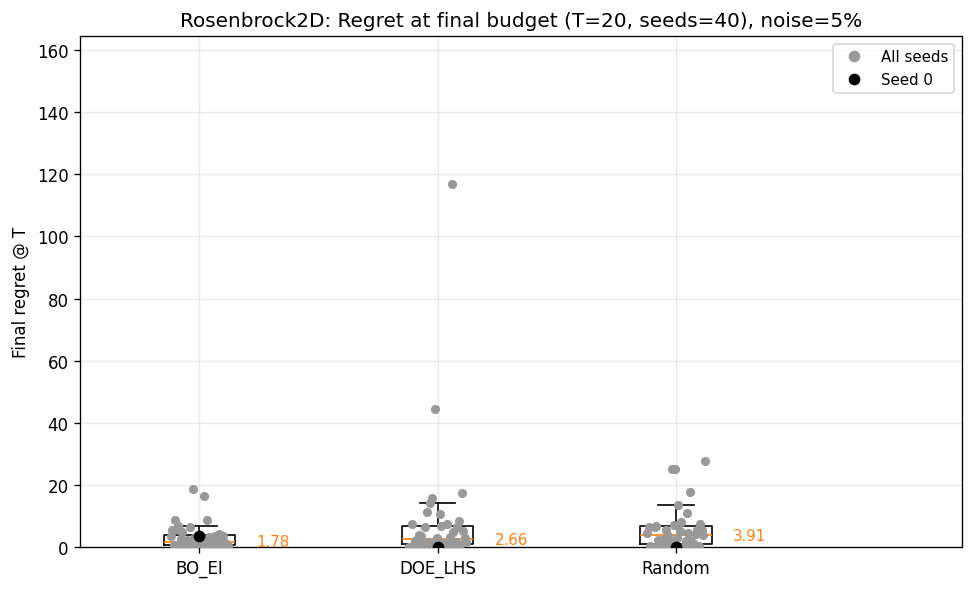

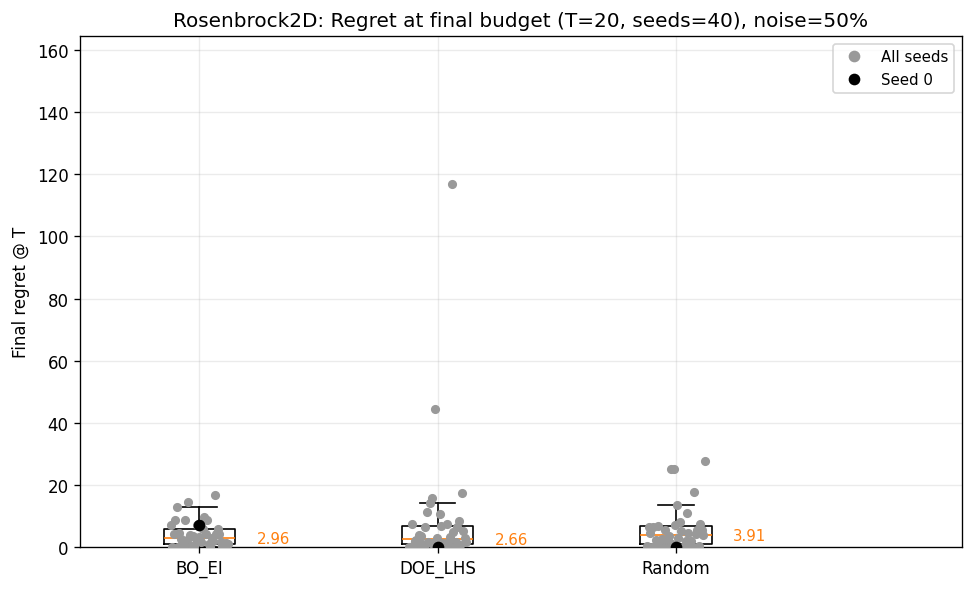

In [48]:
show_all_core_plots(outdir)

In [8]:
show_core_dataframes(outdir)

all_runs.csv shape: (19200, 21)


**Final rows per run (for boxplots):**

,exp_name,problem,method,dim,seed,noise_seed,noise_pct,sigma_noise,budget,iter,...,x_uv,x_xy,x,y,y_noisy,best_so_far,best_so_far_obs,regret,regret_obs,time_s
19,SB5_Noise_sensitivity,Branin2D,BO_EI,2,0,777000,0.00,0.000000,20,19,...,"[0.20321578821150577, 0.06297432490851562]","[-1.9517631768274137, 0.9446148736277343]","[-1.9517631768274137, 0.9446148736277343]",81.318456,81.318456,3.274151,3.274151,2.876264,2.876264,0.829356
19179,SB5_Noise_sensitivity,Rosenbrock2D,Random,2,9,777009,0.05,33.446815,20,19,...,"[0.13277453722943044, 0.22609832736317137]","[-1.504155495508253, -1.12190125112045]","[-1.504155495508253, -1.12190125112045]",1151.676981,1172.820803,4.625871,-24.561164,4.625871,-24.561164,0.000000
39,SB5_Noise_sensitivity,Branin2D,BO_EI,2,0,777000,0.20,10.282938,20,19,...,"[0.8296723761442324, 0.8349504775111299]","[7.445085642163486, 12.524257162666949]","[7.445085642163486, 12.524257162666949]",139.546266,137.665216,12.325284,13.079042,11.927397,12.681155,0.809995
59,SB5_Noise_sensitivity,Branin2D,BO_EI,2,0,777000,0.05,2.570735,20,19,...,"[0.8296723761442324, 0.8349504775111299]","[7.445085642163486, 12.524257162666949]","[7.445085642163486, 12.524257162666949]",139.546266,139.076004,12.325284,12.513723,11.927397,12.115836,0.756357
79,SB5_Noise_sensitivity,Branin2D,BO_EI,2,0,777000,0.50,25.707345,20,19,...,"[0.8296723761442324, 0.8349504775111299]","[7.445085642163486, 12.524257162666949]","[7.445085642163486, 12.524257162666949]",139.546266,134.843641,12.325284,9.827844,11.927397,9.429957,0.916744
99,SB5_Noise_sensitivity,Branin2D,BO_EI,2,10,777010,0.00,0.000000,20,19,...,"[0.17526353970371533, 0.3242139404309702]","[-2.37104690444427, 4.863209106464553]","[-2.37104690444427, 4.863209106464553]",34.882429,34.882429,1.212352,1.212352,0.814465,0.814465,1.331289
119,SB5_Noise_sensitivity,Branin2D,BO_EI,2,10,777010,0.20,10.172826,20,19,...,"[0.6707441272896207, 0.0005349661554416851]","[5.06116190934431, 0.008024492331625277]","[5.06116190934431, 0.008024492331625277]",14.833973,4.346334,2.834222,-25.571739,2.436335,-25.969626,0.940890
139,SB5_Noise_sensitivity,Branin2D,BO_EI,2,10,777010,0.05,2.543206,20,19,...,"[0.12697580669414676, 0.6997729750161249]","[-3.0953628995877986, 10.496594625241874]","[-3.0953628995877986, 10.496594625241874]",3.188970,0.567060,2.232861,-6.659774,1.834974,-7.057661,0.882294
17159,SB5_Noise_sensitivity,Rosenbrock2D,Random,2,22,777022,0.20,130.949829,20,19,...,"[0.18578912436902906, 0.5512646099109749]","[-1.287007746584457, 0.20997984219535315]","[-1.287007746584457, 0.20997984219535315]",214.440332,269.097609,6.412934,-250.007363,6.412934,-250.007363,0.000000
17279,SB5_Noise_sensitivity,Rosenbrock2D,Random,2,23,777023,0.50,334.647590,20,19,...,"[0.7453534018221998, 0.4493432829540601]","[1.0049675338637303, -0.20748991302016973]","[1.0049675338637303, -0.20748991302016973]",148.218391,-41.285246,0.308330,-492.111126,0.308330,-492.111126,0.015698


**Aggregate (true regret) for curves:**

,problem,method,budget,noise_pct,iter,median,q25,q75,n
0,Branin2D,BO_EI,20,0.0,0,27.192097,13.890921,70.506640,40.0
1,Branin2D,BO_EI,20,0.0,1,19.269922,8.738699,33.806408,40.0
2,Branin2D,BO_EI,20,0.0,2,15.160100,5.298059,25.242206,40.0
3,Branin2D,BO_EI,20,0.0,3,9.323280,2.834947,18.232169,40.0
4,Branin2D,BO_EI,20,0.0,4,8.039648,2.298759,14.427364,40.0
5,Branin2D,BO_EI,20,0.0,5,6.462237,1.319206,13.167625,40.0
6,Branin2D,BO_EI,20,0.0,6,5.741040,1.274223,9.515726,40.0
7,Branin2D,BO_EI,20,0.0,7,3.296446,1.191522,8.953586,40.0
8,Branin2D,BO_EI,20,0.0,8,2.723142,0.929165,7.661794,40.0
9,Branin2D,BO_EI,20,0.0,9,2.467451,0.875860,4.115428,40.0


**Aggregate (normalized regret) for curves:**

,problem,method,iter,median,q25,q75,noise_pct
0,Branin2D,BO_EI,0,0.169589,0.086634,0.439730,0.0
1,Branin2D,BO_EI,1,0.120181,0.054501,0.210841,0.0
2,Branin2D,BO_EI,2,0.094549,0.033043,0.157429,0.0
3,Branin2D,BO_EI,3,0.058147,0.017681,0.113709,0.0
4,Branin2D,BO_EI,4,0.050141,0.014337,0.089979,0.0
5,Branin2D,BO_EI,5,0.040303,0.008228,0.082123,0.0
6,Branin2D,BO_EI,6,0.035805,0.007947,0.059347,0.0
7,Branin2D,BO_EI,7,0.020559,0.007431,0.055841,0.0
8,Branin2D,BO_EI,8,0.016983,0.005795,0.047784,0.0
9,Branin2D,BO_EI,9,0.015389,0.005462,0.025667,0.0


Plotting methods: ['DOE_LHS', 'BO_EI', 'Random']


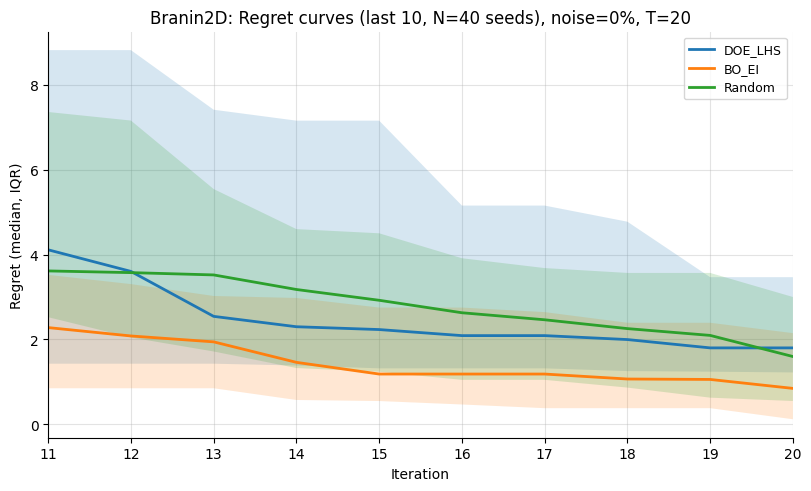

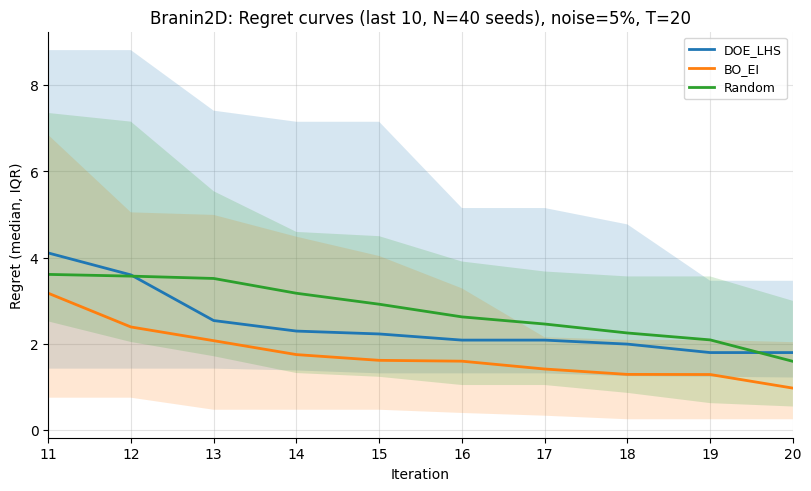

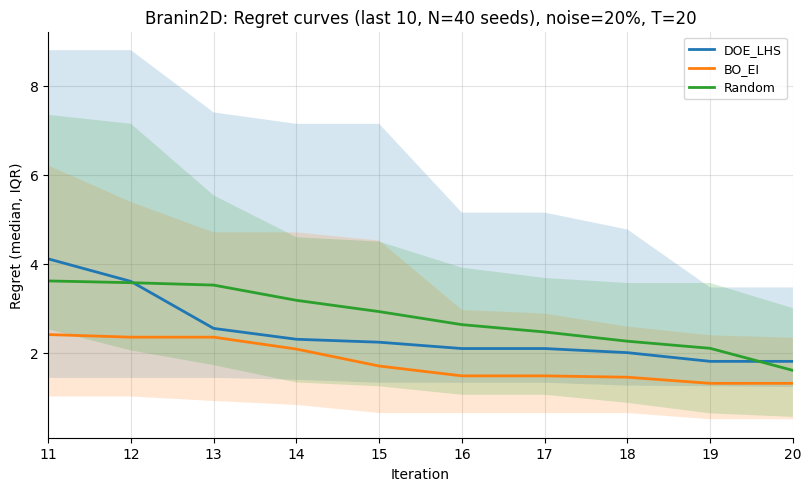

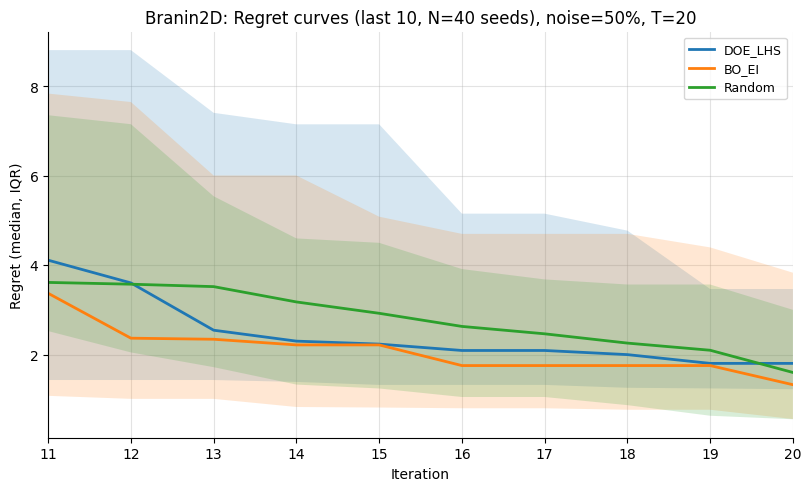

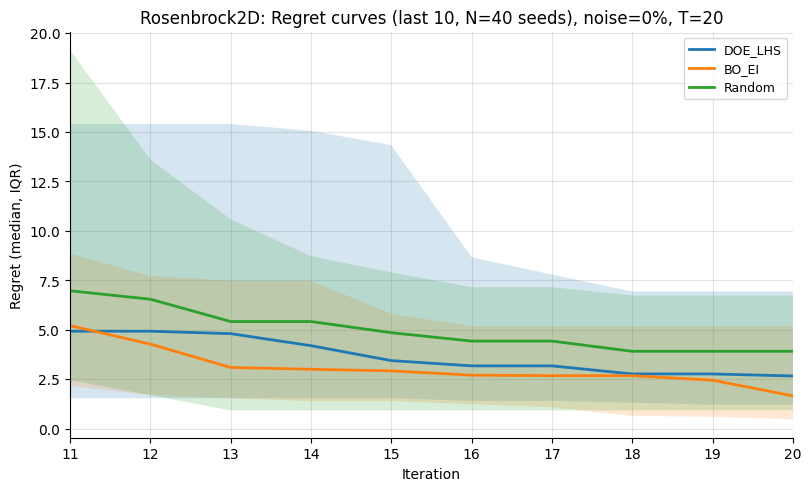

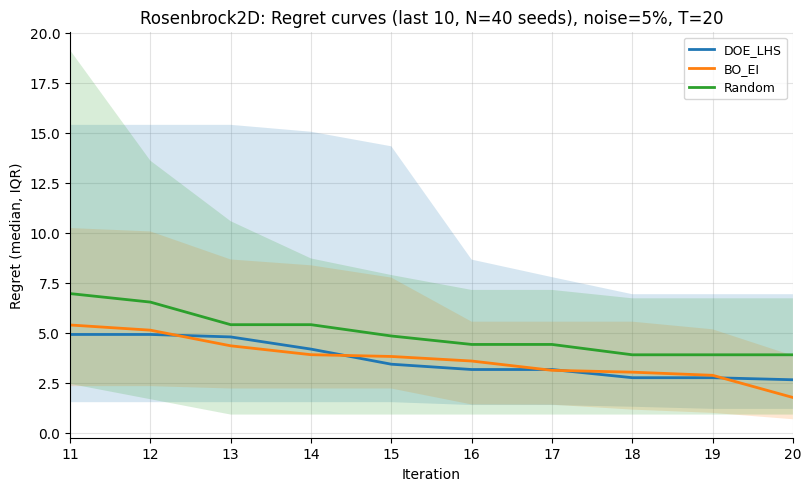

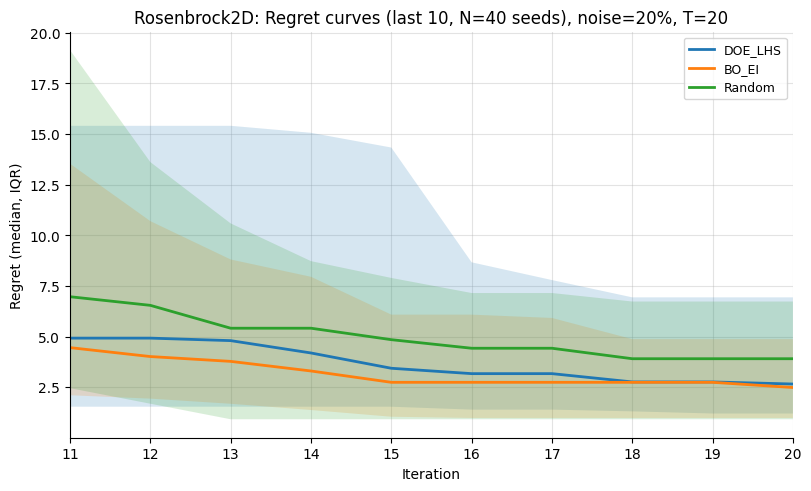

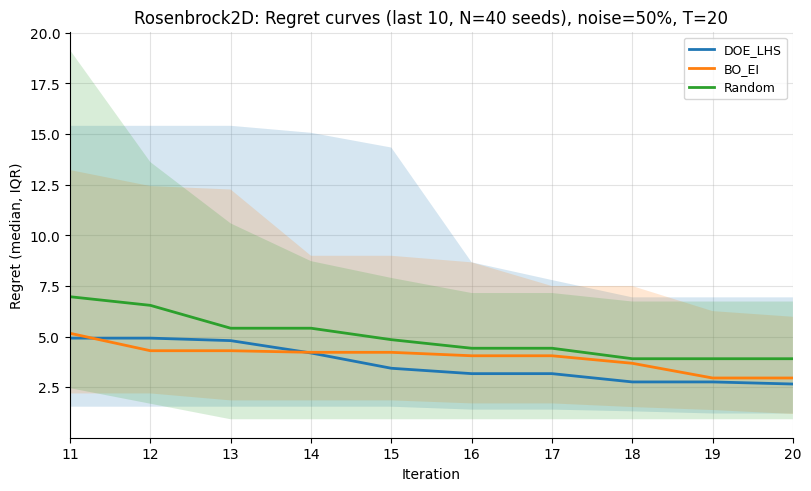

In [49]:
# ----------------------------------- LAST-10 REGRET CURVES (display only) --------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# Daten laden
df_all = load_logs(outdir)
dfn    = add_normalized_regret(df_all.copy())

# volle Aggregate (für T-Bestimmung und Slicing)
agg_true_full = aggregate_regret(df_all, use_observed=False)   # cols: problem, method, [budget], noise_pct, iter, median, q25, q75, n
aggn_full     = aggregate_regret_norm(dfn)                     # cols: problem, method, [budget], noise_pct, iter, median, q25, q75, n

# --- Methoden dynamisch bestimmen (optional Reihenfolge aus main.METHODS respektieren) ---
try:
    import main
    pref_order = list(getattr(main, "METHODS", []))
except Exception:
    pref_order = []

all_methods = sorted(pd.unique(pd.concat([agg_true_full["method"], aggn_full["method"]], ignore_index=True)))
if pref_order:
    order_idx = {m: i for i, m in enumerate(pref_order)}
    methods = sorted(all_methods, key=lambda m: order_idx.get(m, len(pref_order)))
else:
    methods = all_methods

print("Plotting methods:", methods)

def _last_k_by_method(agg: pd.DataFrame, k: int) -> pd.DataFrame:
    """Nimmt je (problem, budget?, noise, method) die letzten k Iterationen (nach iter sortiert)."""
    cols = agg.columns.tolist()
    has_budget = "budget" in agg.columns
    pieces = []
    for p in sorted(agg["problem"].unique()):
        ap = agg[agg["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                present = [m for m in methods if m in set(sub["method"])]
                for m in present:
                    sm = sub[sub["method"] == m].sort_values("iter")
                    iters = sorted(sm["iter"].unique())
                    take = iters[-min(k, len(iters)):]
                    pieces.append(sm[sm["iter"].isin(take)])
    return pd.concat(pieces, ignore_index=True)[cols] if pieces else agg.iloc[0:0]

agg_true_l10 = _last_k_by_method(agg_true_full, k=10)
aggn_l10     = _last_k_by_method(aggn_full,     k=10)

def _Tinfo_from_full(agg_full: pd.DataFrame):
    """Ermittelt T_end und x-Offset je (problem, noise[, budget])."""
    info = {}
    has_budget = "budget" in agg_full.columns
    for p in agg_full["problem"].unique():
        ap = agg_full[agg_full["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                it_min = int(sub["iter"].min())
                it_max = int(sub["iter"].max())
                x_off  = 1 if it_min == 0 else 0   # 0-based iter → +1
                T_end  = it_max + x_off            # z.B. 49+1 = 50
                info[(p, n, b)] = (T_end, x_off)
    return info

Tinfo_true = _Tinfo_from_full(agg_true_full)
Tinfo_norm = _Tinfo_from_full(aggn_full)

def _plot_windowed_curves(slice_lastk: pd.DataFrame, Tinfo_full: dict,
                          title_prefix: str, ylabel: str, k:int=10):
    """Zeigt die letzten k Punkte, x-Achse endet exakt bei T=max und beginnt bei T-k+1."""
    if slice_lastk.empty:
        print("[warn] No data to plot.")
        return
    has_budget = "budget" in slice_lastk.columns
    for p in sorted(slice_lastk["problem"].unique()):
        ap = slice_lastk[slice_lastk["problem"] == p]
        budgets = sorted(ap["budget"].unique()) if has_budget else [None]
        for b in budgets:
            ab = ap if b is None else ap[ap["budget"] == b]
            for n in sorted(ab["noise_pct"].unique()):
                key = (p, n, b)
                if key not in Tinfo_full:
                    continue
                T_end, x_off = Tinfo_full[key]
                xmin, xmax = max(1, T_end - (k - 1)), T_end

                sub = ab[ab["noise_pct"] == n]
                if sub.empty:
                    continue
                # Methoden für dieses Subset dynamisch (in gewünschter Reihenfolge)
                present = [m for m in methods if m in set(sub["method"])]

                fig, ax = plt.subplots(figsize=(8, 4.8))
                for m in present:
                    sm = sub[sub["method"] == m].sort_values("iter")
                    x  = sm["iter"].to_numpy(dtype=float) + x_off
                    y  = sm["median"].to_numpy(dtype=float)
                    q1 = sm["q25"].to_numpy(dtype=float)
                    q3 = sm["q75"].to_numpy(dtype=float)
                    ax.plot(x, y, label=m, linewidth=2.0)
                    ax.fill_between(x, q1, q3, alpha=0.18)

                seeds_txt = ""
                if "n" in sub.columns and sub["n"].notna().any():
                    try: seeds_txt = f", N={int(sub['n'].max())} seeds"
                    except: pass

                title = f"{p}: {title_prefix} (last {k}{seeds_txt}), noise={int(round(100*float(n)))}%"
                if b is not None:
                    title += f", T={int(b)}"

                ax.set_title(title)
                ax.set_xlabel("Iteration")
                ax.set_ylabel(ylabel)
                ax.set_xlim(xmin, xmax)                         # endet garantiert bei T=max
                xt = list(range(xmin, xmax+1))
                if len(xt) > 10:
                    step = int(np.ceil(len(xt)/10))
                    xt = list(range(xmin, xmax+1, step))
                    if xt[-1] != xmax:
                        xt.append(xmax)
                ax.set_xticks(xt)
                ax.grid(True, alpha=0.35); ax.set_axisbelow(True)
                for s in ("top","right"): ax.spines[s].set_visible(False)
                ax.legend(loc="upper right")
                plt.show()

# Anzeigen (nur display)
_plot_windowed_curves(agg_true_l10, Tinfo_true, title_prefix="Regret curves",            ylabel="Regret (median, IQR)", k=10)
# _plot_windowed_curves(aggn_l10,     Tinfo_norm, title_prefix="Normalized regret curves", ylabel="Normalized regret (median, IQR)", k=10)


In [40]:
# --------------------- INLINE BOXPLOT: alle Methoden je Noise-Level (Final regret @T) ---------------------
from pathlib import Path
from typing import Optional, Sequence
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms as mtransforms
from IPython.display import Markdown, display
import evaluator as ev

# optionaler Style
try:
    import tb_style
    tb_style.apply()
except Exception:
    pass

def _value_col_from_metric(metric: str) -> str:
    m = metric.lower()
    if m in ("regret","true"): return "regret"
    if m in ("regret_obs","obs"): return "regret_obs"
    if m in ("regret_norm","norm"): return "regret_norm"
    if m in ("best_so_far","best"): return "best_so_far"
    if m in ("best_so_far_obs","best_obs"): return "best_so_far_obs"
    raise ValueError("metric must be one of {'regret','regret_obs','regret_norm','best_so_far','best_so_far_obs'}")

def _ylabel_from_metric(metric: str) -> str:
    m = metric.lower()
    if m == "regret": return "Final regret @ T"
    if m == "regret_obs": return "Final observed regret @ T"
    if m == "regret_norm": return "Final normalized regret @ T"
    if m == "best_so_far": return "Final best value @ T"
    if m == "best_so_far_obs": return "Final observed best value @ T"
    return metric

# def plot_box_all_methods_by_noise_inline(
#     outdir: Path,
#     problem: str = "Branin2D",
#     methods: Optional[Sequence[str]] = None,   # None → alle im Datensatz (ggf. Reihenfolge aus main.METHODS)
#     metric: str = "regret",
#     budget: Optional[int] = None,
#     show_all_seeds: bool = True,
#     highlight_seed: Optional[int] = None,
#     jitter: float = 0.12,
#     box_width: float = 0.20,        # Breite einzelner Boxen
#     method_sep: float = 0.30,       # Abstand zwischen Methoden innerhalb eines Noise-Clusters
#     cluster_sep: float = 1.25,   # <— NEU: Abstand zwischen Noise-Clustern
#     bottom_pad: float = 0.30,       # Platz unten für 2 Labelzeilen
#     ypad: float = 0.05,
#     decimals: int = 3,
#     median_display: str = "table",   # 'table' | 'none'
#     method_y: float = -0.06,         # y-Pos (achsenrelativ) für Methodenlabel
#     noise_y: float = -0.12,          # y-Pos (achsenrelativ) für Noise-Label
# ):
#     col = _value_col_from_metric(metric)
#     ylabel = _ylabel_from_metric(metric)

#     df = ev.load_logs(outdir)
#     # final rows per run im Projektstil
#     try:
#         base = ev._final_rows_per_run(df)
#     except Exception:
#         keys = ["problem","method","seed","budget"]
#         if "noise_pct" in df.columns: keys.append("noise_pct")
#         base = df.sort_values("iter").groupby(keys, as_index=False).tail(1)
#     if base.empty:
#         raise ValueError("No data after final-row filtering.")
#     if "noise_pct" not in base.columns:
#         base = base.copy()
#         base["noise_pct"] = 0.0

#     sub = base[base["problem"] == problem].copy()
#     if sub.empty:
#         raise ValueError(f"No rows for problem={problem}")

#     # Budget / T
#     if "budget" in sub.columns and sub["budget"].notna().any():
#         if budget is None:
#             budget = int(sub["budget"].max())
#         sub = sub[sub["budget"] == budget]
#     else:
#         it_min = int(sub["iter"].min()); it_max = int(sub["iter"].max())
#         x_off  = (1 if it_min == 0 else 0)
#         budget = it_max + x_off
#     if sub.empty:
#         raise ValueError("No rows at the requested T (budget).")

#     # Methoden: falls None → alle in sub; Reihenfolge bevorzugt aus main.METHODS
#     if methods is None:
#         try:
#             import main
#             pref_order = list(getattr(main, "METHODS", []))
#         except Exception:
#             pref_order = []
#         all_methods = sorted(sub["method"].unique().tolist())
#         if pref_order:
#             order_idx = {m:i for i,m in enumerate(pref_order)}
#             methods = sorted(all_methods, key=lambda m: order_idx.get(m, len(pref_order)))
#         else:
#             methods = all_methods
#     else:
#         methods = list(methods)

#     # Noise-Levels (alle vorhandenen im Subset)
#     noise_levels = sorted(sub["noise_pct"].unique().tolist())
#     labels_noise = [f"{int(round(100*n))}%" for n in noise_levels]

#     # Globale y-Limits
#     data_all = []
#     for m in methods:
#         for n in noise_levels:
#             vals = sub[(sub["method"] == m) & (sub["noise_pct"] == n)][col].to_numpy()
#             if vals.size:
#                 data_all.append(vals)
#     y_min = 0.0 if col in ("regret","regret_obs","regret_norm") else (
#         float(np.nanmin([np.nanmin(d) for d in data_all])) if data_all else 0.0
#     )
#     ymax = (np.nanmax([np.nanmax(d) for d in data_all]) if data_all else 1.0)
#     y_max = (1.0 if not np.isfinite(ymax) else ymax) * (1.0 + ypad)

#     # Plot
#     fig, ax = plt.subplots(figsize=(14, 6.5))
#     centers = (np.arange(len(noise_levels), dtype=float) * cluster_sep) + 1.0
#     M = len(methods)
#     # Offsets pro Methode um jeden Cluster-Mittelpunkt (symmetrisch)
#     offs = ((np.arange(M) - (M-1)/2.0) * method_sep).astype(float)

#     # Boxen pro Methode zeichnen
#     for j, m in enumerate(methods):
#         pos_j, data_j = [], []
#         for i, n in enumerate(noise_levels):
#             vals = sub[(sub["method"] == m) & (sub["noise_pct"] == n)][col].to_numpy()
#             if vals.size:
#                 pos_j.append(centers[i] + offs[j])
#                 data_j.append(vals)
#         if data_j:
#             ax.boxplot(data_j, positions=pos_j, widths=box_width, showfliers=False)
#             # Seeds (grau)
#             if show_all_seeds:
#                 for x0, vals in zip(pos_j, data_j):
#                     xs = x0 + (np.linspace(-jitter, jitter, len(vals)) if len(vals) > 1 else np.array([0.0]))
#                     ax.scatter(xs, vals, s=20, c="0.6", zorder=3)
#         # Methoden-Label unter jede vorhandene Box
#         trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
#         for x0 in pos_j:
#             ax.text(x0, method_y, m, transform=trans, ha="center", va="top", fontsize=9, clip_on=False)

#     # Highlight-Seed (falls gewünscht)
#     if highlight_seed is not None and "seed" in sub.columns:
#         hs = sub[sub["seed"] == int(highlight_seed)]
#         for j, m in enumerate(methods):
#             for i, n in enumerate(noise_levels):
#                 vals = hs[(hs["method"] == m) & (hs["noise_pct"] == n)][col].to_numpy()
#                 if vals.size:
#                     x0 = centers[i] + offs[j]
#                     ax.scatter(np.repeat(x0, vals.size), vals, s=36, c="black", zorder=4)

#     # Noise-Labels zentriert unter jeden Cluster
#     trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
#     for c, lab in zip(centers, labels_noise):
#         ax.text(c, noise_y, lab, transform=trans, ha="center", va="top", fontsize=9, clip_on=False)

#     # Achsen & Grid
#     ax.set_ylim(y_min, y_max)
#     ax.set_ylabel(ylabel)
#     ax.grid(True, alpha=0.35); ax.set_axisbelow(True)
#     for s in ("top","right"): ax.spines[s].set_visible(False)
#     ax.set_xticks([]); ax.set_xlabel("")
#     fig.subplots_adjust(bottom=max(bottom_pad, fig.subplotpars.bottom))

#     # Titel
#     n_seeds_total = int(sub["seed"].nunique()) if "seed" in sub.columns else int(len(sub))
#     ax.set_title(f"{problem} — All methods — {ylabel.replace('Final ','').replace(' @ T',' at T')} (N≈{n_seeds_total}), T={budget}")
#     plt.show()

#     # Zusammenfassungstabelle (Median usw.)
#     summary = (
#         sub.groupby(["noise_pct","method"])[col]
#         .agg(n="count", median="median",
#              q25=lambda s: s.quantile(0.25), q75=lambda s: s.quantile(0.75),
#              mean="mean", std="std", min="min", max="max")
#         .reset_index()
#         .rename(columns={"noise_pct":"alpha"})
#     )
#     summary["alpha"] = summary["alpha"].map(lambda n: f"{int(round(100*n))}%")
#     summary = summary[["alpha","method","n","median","q25","q75","mean","std","min","max"]].round(decimals)
#     if median_display == "table":
#         display(Markdown("**Per-noise × method summary (final @ T):**"))
#         display(summary)
#     return summary

def plot_box_all_methods_by_noise_inline(
    outdir: Path,
    problem: str = "Branin2D",
    methods: Optional[Sequence[str]] = None,   # globale Reihenfolge/Default-Set
    metric: str = "regret",
    budget: Optional[int] = None,
    show_all_seeds: bool = True,
    highlight_seed: Optional[int] = None,
    jitter: float = 0.12,
    box_width: float = 0.18,
    method_sep: float = 0.24,
    cluster_sep: float = 1.0,        # Abstand zwischen Noise-Clustern
    bottom_pad: float = 0.30,
    ypad: float = 0.05,
    y_min_override: Optional[float] = None,   # <— NEU
    y_max_override: Optional[float] = None,   # <— NEU
    decimals: int = 3,
    median_display: str = "table",   # 'table' | 'none'
    method_y: float = -0.06,
    noise_y: float = -0.12,
    noise_method_map: Optional[dict] = None,   # NEU: {alpha: [method,...]}, z.B. {0.0:["DOE_LHS","BO_EI","BO_KG","Random"], 0.2:["BO_EI"], 0.5:["BO_EI"]}
):
    # --- Helper ---
    def _norm_alpha_key(a):
        # erlaubt 0, 0.0, 0.2, "0%", "20%" usw.
        if isinstance(a, str) and a.endswith("%"):
            return round(float(a[:-1]) / 100.0, 5)
        return round(float(a), 5)

    col = _value_col_from_metric(metric)
    ylabel = _ylabel_from_metric(metric)

    df = ev.load_logs(outdir)
    try:
        base = ev._final_rows_per_run(df)
    except Exception:
        keys = ["problem","method","seed","budget"]
        if "noise_pct" in df.columns: keys.append("noise_pct")
        base = df.sort_values("iter").groupby(keys, as_index=False).tail(1)
    if base.empty:
        raise ValueError("No data after final-row filtering.")
    if "noise_pct" not in base.columns:
        base = base.copy(); base["noise_pct"] = 0.0

    sub = base[base["problem"] == problem].copy()
    if sub.empty:
        raise ValueError(f"No rows for problem={problem}")

    # T bestimmen
    if "budget" in sub.columns and sub["budget"].notna().any():
        if budget is None: budget = int(sub["budget"].max())
        sub = sub[sub["budget"] == budget]
    else:
        it_min = int(sub["iter"].min()); it_max = int(sub["iter"].max())
        x_off  = 1 if it_min == 0 else 0
        budget = it_max + x_off
    if sub.empty:
        raise ValueError("No rows at the requested T (budget).")

    # globale Methodenreihenfolge
    if methods is None:
        try:
            import main
            pref_order = list(getattr(main, "METHODS", []))
        except Exception:
            pref_order = []
        all_methods = sorted(sub["method"].unique().tolist())
        if pref_order:
            order_idx = {m:i for i,m in enumerate(pref_order)}
            methods = sorted(all_methods, key=lambda m: order_idx.get(m, len(pref_order)))
        else:
            methods = all_methods
    else:
        methods = list(methods)

    # verfügbare Noise-Level
    noise_levels = sorted(sub["noise_pct"].unique().tolist())
    labels_noise = [f"{int(round(100*n))}%" for n in noise_levels]

    # Map normalisieren
    if noise_method_map:
        noise_method_map = { _norm_alpha_key(k): [m for m in methods if m in set(v)]
                             for k, v in noise_method_map.items() }

    # Y-Limits über tatsächlich angezeigte Daten
    data_all = []
    cluster_methods = []
    for n in noise_levels:
        mlist = noise_method_map.get(_norm_alpha_key(n), methods) if noise_method_map else methods
        mlist = [m for m in mlist if m in set(sub["method"])]
        cluster_methods.append(mlist)
        for m in mlist:
            vals = sub[(sub["method"] == m) & (sub["noise_pct"] == n)][col].to_numpy()
            if vals.size: data_all.append(vals)
    y_min = 0.0 if col in ("regret","regret_obs","regret_norm") else (
        float(np.nanmin([np.nanmin(d) for d in data_all])) if data_all else 0.0
    )
    ymax = (np.nanmax([np.nanmax(d) for d in data_all]) if data_all else 1.0)
    y_max = (1.0 if not np.isfinite(ymax) else ymax) * (1.0 + ypad)

    # Plot
    fig, ax = plt.subplots(figsize=(11, 6.5))
    centers = (np.arange(len(noise_levels), dtype=float) * cluster_sep) + 1.0
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    shown_rows = []  # für Tabelle

    for i, n in enumerate(noise_levels):
        mlist = cluster_methods[i]
        if not mlist:
            continue
        M = len(mlist)
        offs = ((np.arange(M) - (M-1)/2.0) * method_sep).astype(float)
        for j, m in enumerate(mlist):
            vals = sub[(sub["method"] == m) & (sub["noise_pct"] == n)][col].to_numpy()
            if vals.size:
                x0 = centers[i] + offs[j]
                ax.boxplot([vals], positions=[x0], widths=box_width, showfliers=False)
                if show_all_seeds:
                    xs = x0 + (np.linspace(-jitter, jitter, len(vals)) if len(vals) > 1 else np.array([0.0]))
                    ax.scatter(xs, vals, s=20, c="0.6", zorder=3)
                # Methodenlabel direkt unter der Achse
                ax.text(x0, method_y, m, transform=trans, ha="center", va="top", fontsize=9, clip_on=False)
                # für Tabelle merken
                for v in vals:
                    shown_rows.append((n, m, float(v)))
        # Noise-Label zentriert unter dem Cluster
        ax.text(centers[i], noise_y, f"{int(round(100*n))}%", transform=trans, ha="center", va="top", fontsize=9, clip_on=False)

    # Highlight-Seed optional (zeichnet Punkte schwarz dort, wo vorhanden)
    if highlight_seed is not None and "seed" in sub.columns:
        hs = sub[sub["seed"] == int(highlight_seed)]
        for i, n in enumerate(noise_levels):
            mlist = cluster_methods[i]
            M = len(mlist)
            offs = ((np.arange(M) - (M-1)/2.0) * method_sep).astype(float)
            for j, m in enumerate(mlist):
                vals = hs[(hs["method"] == m) & (hs["noise_pct"] == n)][col].to_numpy()
                if vals.size:
                    x0 = centers[i] + offs[j]
                    ax.scatter(np.repeat(x0, vals.size), vals, s=36, c="black", zorder=4)

   # --- Achsen & Grid (mit harten Y-Limits/Overrides) ---
    ax_ymin, ax_ymax = y_min, y_max
    if y_min_override is not None:
        ax_ymin = float(y_min_override)
    if y_max_override is not None:
        ax_ymax = float(y_max_override)

    # (optional) Debug:
    # print(f"[boxplot] y-lims used → bottom={ax_ymin}, top={ax_ymax}")

    ax.set_ylim(ax_ymin, ax_ymax)
    ax.set_autoscale_on(False)

    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.35); ax.set_axisbelow(True)
    for s in ("top","right"):
        ax.spines[s].set_visible(False)

    # Standard-x-Ticks ausblenden; zwei Zeilen Labels unten bleiben
    ax.set_xticks([]); ax.set_xlabel("")
    fig.subplots_adjust(bottom=max(bottom_pad, fig.subplotpars.bottom))

    ax.set_xticks([]); ax.set_xlabel("")
    fig.subplots_adjust(bottom=max(bottom_pad, fig.subplotpars.bottom))
    n_seeds_total = int(sub["seed"].nunique()) if "seed" in sub.columns else int(len(sub))
    ax.set_title(f"{problem} — Selected methods per noise — {ylabel.replace('Final ','').replace(' @ T',' at T')} (N={n_seeds_total}), T={budget}")
    plt.show()

    # Tabelle nur über angezeigte Kombinationen
    if median_display == "table" and shown_rows:
        df_tab = pd.DataFrame(shown_rows, columns=["alpha","method",col])
        summary = (
            df_tab.groupby(["alpha","method"])[col]
            .agg(n="count", median="median",
                 q25=lambda s: s.quantile(0.25), q75=lambda s: s.quantile(0.75),
                 mean="mean", std="std", min="min", max="max")
            .reset_index()
        )
        summary["alpha"] = summary["alpha"].map(lambda n: f"{int(round(100*n))}%")
        summary = summary[["alpha","method","n","median","q25","q75","mean","std","min","max"]].round(decimals)
        display(Markdown("**Per-noise × method summary (final @ T, shown only):**"))
        display(summary)
        return summary
    return None



In [11]:
# breite der plosts:
# fig, ax = plt.subplots(figsize=(14, 6.5))  # breiter

# Abstand der Noise cluster:
#method_sep=0.28   # statt 0.24
#box_width=0.20    # ggf. minimal anheben


C:\Users\marti\AppData\Local\Temp\ipykernel_50580\3814206889.py:353: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=max(bottom_pad, fig.subplotpars.bottom))
C:\Users\marti\AppData\Local\Temp\ipykernel_50580\3814206889.py:356: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=max(bottom_pad, fig.subplotpars.bottom))


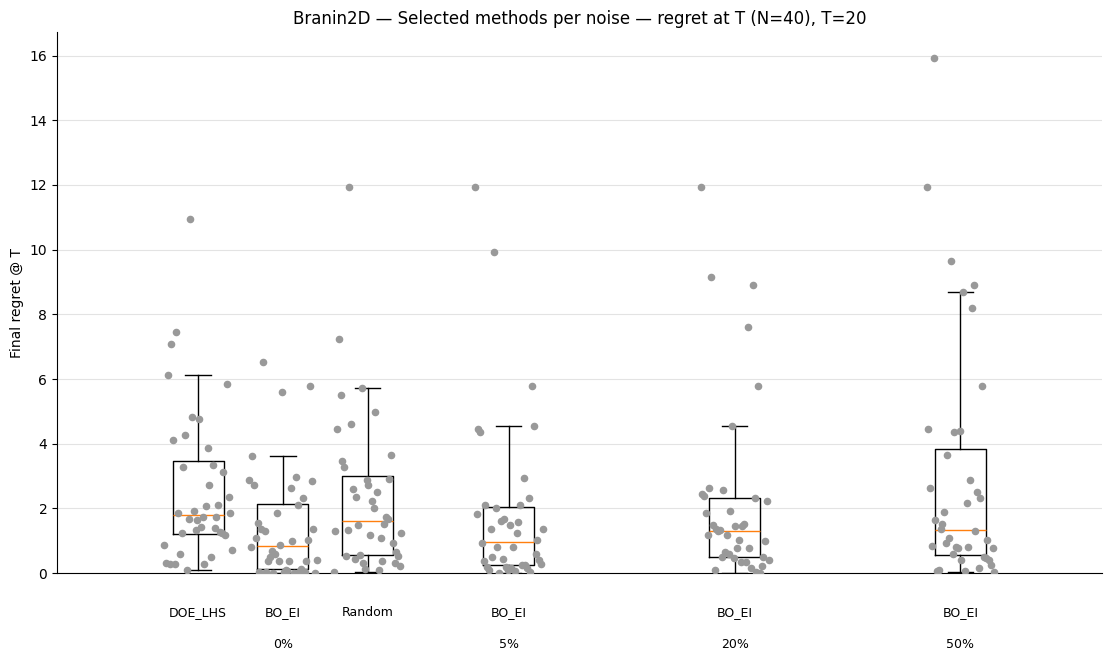

**Per-noise × method summary (final @ T, shown only):**

,alpha,method,n,median,q25,q75,mean,std,min,max
0,0%,BO_EI,40,0.847,0.120,2.148,1.408,1.663,0.002,6.521
1,0%,DOE_LHS,40,1.801,1.223,3.466,2.594,2.340,0.094,10.937
2,0%,Random,40,1.598,0.550,3.000,2.319,2.360,0.043,11.938
3,5%,BO_EI,40,0.977,0.255,2.042,1.806,2.551,0.018,11.927
4,20%,BO_EI,40,1.306,0.497,2.332,2.157,2.751,0.011,11.927
5,50%,BO_EI,40,1.324,0.555,3.831,2.905,3.686,0.042,15.922


In [41]:
# _ = plot_box_all_methods_by_noise_inline(
#     outdir,
#     problem="Branin2D",  # ggf. "Branin" je nach Label in all_runs.csv
#     methods=("DOE_LHS","BO_EI","Random"),  # <- mehrere Methoden korrekt
#     metric="regret",
#     budget=20,
#     median_display="table",
#     method_y=-0.06,
#     noise_y=-0.12
# )

_ = plot_box_all_methods_by_noise_inline(
    outdir,
    problem="Branin2D",
    methods=("DOE_LHS","BO_EI","Random"),
    metric="regret",
    budget=20,
    cluster_sep=0.8,
    method_sep=0.3,
    noise_method_map={
        0.0: ("DOE_LHS","BO_EI","Random"),
        0.05: ("BO_EI",),
        0.2: ("BO_EI",),
        0.5: ("BO_EI",),
    },
    median_display="table",
    method_y=-0.06,
    noise_y=-0.12,
    # y_max_override=0.0,   # <— kein override
    # y_min_override=0.0     # optional: unten auf 0 fixieren
)



C:\Users\marti\AppData\Local\Temp\ipykernel_50580\3814206889.py:353: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=max(bottom_pad, fig.subplotpars.bottom))
C:\Users\marti\AppData\Local\Temp\ipykernel_50580\3814206889.py:356: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(bottom=max(bottom_pad, fig.subplotpars.bottom))


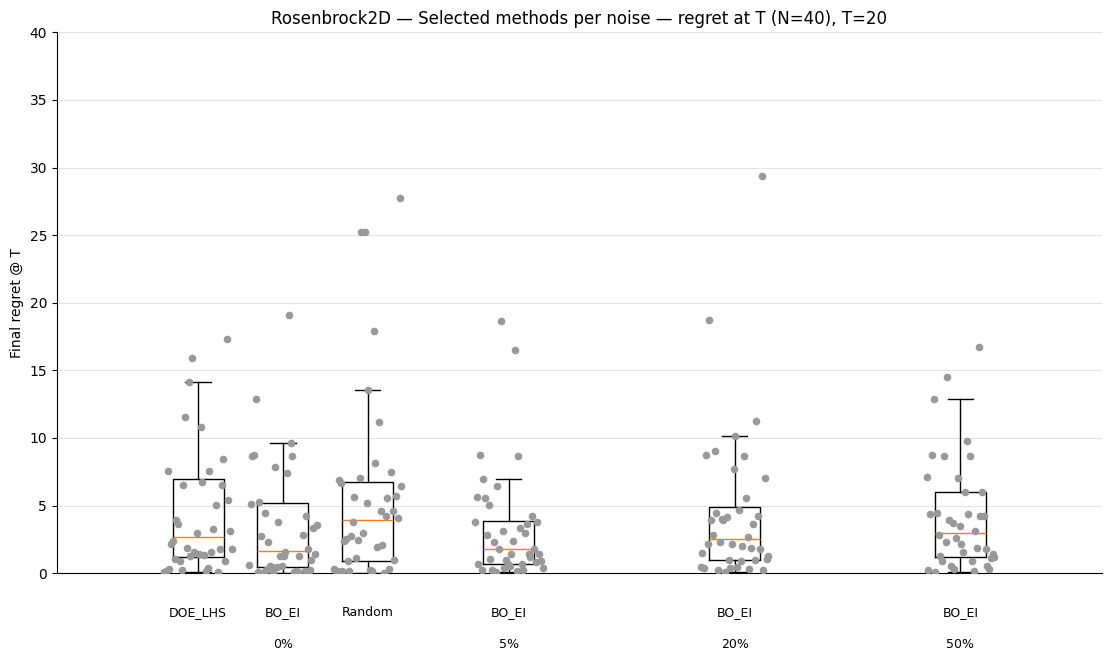

**Per-noise × method summary (final @ T, shown only):**

,alpha,method,n,median,q25,q75,mean,std,min,max
0,0%,BO_EI,40,1.658,0.475,5.177,7.260,24.578,0.030,156.642
1,0%,DOE_LHS,40,2.663,1.208,6.940,8.076,19.274,0.065,116.802
2,0%,Random,40,3.912,0.924,6.735,5.713,7.037,0.018,27.753
3,5%,BO_EI,40,1.777,0.689,3.869,3.287,4.071,0.046,18.673
4,20%,BO_EI,40,2.491,0.987,4.879,4.400,5.608,0.090,29.367
5,50%,BO_EI,40,2.961,1.184,5.982,4.144,4.078,0.101,16.713


In [42]:
# _ = plot_box_all_methods_by_noise_inline(
#     outdir,
#     problem="Branin2D",  # ggf. "Branin" je nach Label in all_runs.csv
#     methods=("DOE_LHS","BO_EI","Random"),  # <- mehrere Methoden korrekt
#     metric="regret",
#     budget=20,
#     median_display="table",
#     method_y=-0.06,
#     noise_y=-0.12
# )

_ = plot_box_all_methods_by_noise_inline(
    outdir,
    problem="Rosenbrock2D",
    methods=("DOE_LHS","BO_EI","Random"),
    metric="regret",
    budget=20,
    cluster_sep=0.8,
    method_sep=0.3,
    noise_method_map={
        0.0: ("DOE_LHS","BO_EI","Random"),
        0.05: ("BO_EI",),
        0.2: ("BO_EI",),
        0.5: ("BO_EI",),
    },
    median_display="table",
    method_y=-0.06,
    noise_y=-0.12,
    y_max_override=40.0,   # <— hier hart auf 40 setzen
    y_min_override=0.0     # optional: unten auf 0 fixieren
)



In [ ]:
_ = plot_box_all_methods_by_noise_inline(
    outdir,
    problem="Rosenbrock2D",  # ggf. "Branin" je nach Label in all_runs.csv
    methods=("DOE_LHS","BO_EI","Random"),  # <- mehrere Methoden korrekt
    metric="regret",
    budget=20,
    median_display="table",
    method_y=-0.06,
    noise_y=-0.12
)